<a href="https://colab.research.google.com/github/manm0han/NYC-Taxi-Trip-Time-Prediction/blob/main/Copy_of_NYC_Taxi_Trip_Time_Prediction_Capstone_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <b><u> Project Title : Taxi trip time Prediction : Predicting total ride duration of taxi trips in New York City</u></b>

## <b> Problem Description </b>

### Your task is to build a model that predicts the total ride duration of taxi trips in New York City. Your primary dataset is one released by the NYC Taxi and Limousine Commission, which includes pickup time, geo-coordinates, number of passengers, and several other variables.

## <b> Data Description </b>

### The dataset is based on the 2016 NYC Yellow Cab trip record data made available in Big Query on Google Cloud Platform. The data was originally published by the NYC Taxi and Limousine Commission (TLC). The data was sampled and cleaned for the purposes of this project. Based on individual trip attributes, you should predict the duration of each trip in the test set.

### <b>NYC Taxi Data.csv</b> - the training set (contains 1458644 trip records)


### Data fields
* #### id - a unique identifier for each trip
* #### vendor_id - a code indicating the provider associated with the trip record
* #### pickup_datetime - date and time when the meter was engaged
* #### dropoff_datetime - date and time when the meter was disengaged
* #### passenger_count - the number of passengers in the vehicle (driver entered value)
* #### pickup_longitude - the longitude where the meter was engaged
* #### pickup_latitude - the latitude where the meter was engaged
* #### dropoff_longitude - the longitude where the meter was disengaged
* #### dropoff_latitude - the latitude where the meter was disengaged
* #### store_and_fwd_flag - This flag indicates whether the trip record was held in vehicle memory before sending to the vendor because the vehicle did not have a connection to the server - Y=store and forward; N=not a store and forward trip
* #### trip_duration - duration of the trip in seconds

In [2]:
import pandas as pd
import numpy as np
import datetime

from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from numpy import math
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import ElasticNet

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
df = pd.read_csv('/content/drive/MyDrive/Almabetter/Regression capstone project/Taxi time prediction project/Copy of NYC Taxi Data.csv')

In [5]:
df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


In [6]:
df.drop(['id', 'passenger_count', 'store_and_fwd_flag'], inplace = True, axis = 1)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 8 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   vendor_id          1458644 non-null  int64  
 1   pickup_datetime    1458644 non-null  object 
 2   dropoff_datetime   1458644 non-null  object 
 3   pickup_longitude   1458644 non-null  float64
 4   pickup_latitude    1458644 non-null  float64
 5   dropoff_longitude  1458644 non-null  float64
 6   dropoff_latitude   1458644 non-null  float64
 7   trip_duration      1458644 non-null  int64  
dtypes: float64(4), int64(2), object(2)
memory usage: 89.0+ MB


In [8]:
df.describe()

,vendor_id,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration
count,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06
mean,1.534950e+00,-7.397349e+01,4.075092e+01,-7.397342e+01,4.075180e+01,9.594923e+02
std,4.987772e-01,7.090186e-02,3.288119e-02,7.064327e-02,3.589056e-02,5.237432e+03
min,1.000000e+00,-1.219333e+02,3.435970e+01,-1.219333e+02,3.218114e+01,1.000000e+00
25%,1.000000e+00,-7.399187e+01,4.073735e+01,-7.399133e+01,4.073588e+01,3.970000e+02
50%,2.000000e+00,-7.398174e+01,4.075410e+01,-7.397975e+01,4.075452e+01,6.620000e+02
75%,2.000000e+00,-7.396733e+01,4.076836e+01,-7.396301e+01,4.076981e+01,1.075000e+03
max,2.000000e+00,-6.133553e+01,5.188108e+01,-6.133553e+01,4.392103e+01,3.526282e+06


In [9]:
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])
df['dropoff_datetime'] = pd.to_datetime(df['dropoff_datetime'])

In [10]:
df['pickup_day'] = df['pickup_datetime'].dt.day_name()
df['dropoff_day'] = df['dropoff_datetime'].dt.day_name()

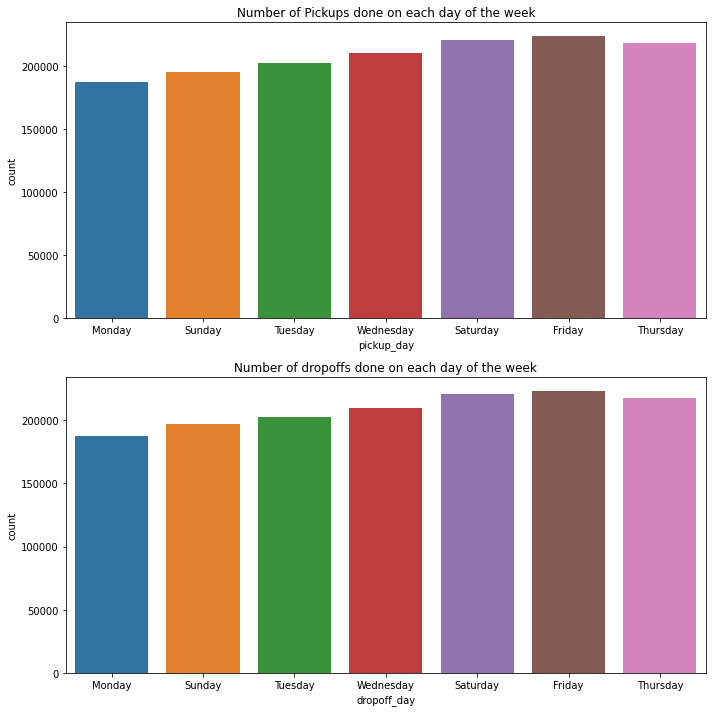

In [11]:
figure,ax = plt.subplots(nrows=2,ncols=1,figsize=(10,10))
sns.countplot(x='pickup_day',data=df,ax=ax[0])
ax[0].set_title('Number of Pickups done on each day of the week')
sns.countplot(x='dropoff_day',data=df,ax=ax[1])
ax[1].set_title('Number of dropoffs done on each day of the week')
plt.tight_layout()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


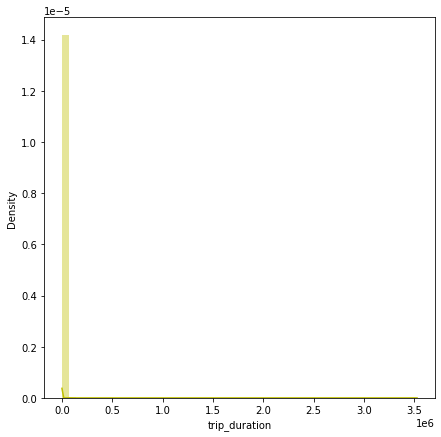

In [12]:
plt.figure(figsize=(7,7))
sns.distplot(df['trip_duration'],color="y")

In [13]:
df['trip_duration'].nlargest(10)

978383     3526282
924150     2227612
680594     2049578
355003     1939736
1234291      86392
295382       86391
73816        86390
59891        86387
1360439      86385
753765       86379
Name: trip_duration, dtype: int64

In [14]:
df = df[df['trip_duration'] <= 86392]

In [15]:
df['trip_duration'].nlargest(10)

1234291    86392
295382     86391
73816      86390
59891      86387
1360439    86385
753765     86379
91717      86378
1221666    86378
66346      86377
1138915    86377
Name: trip_duration, dtype: int64

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


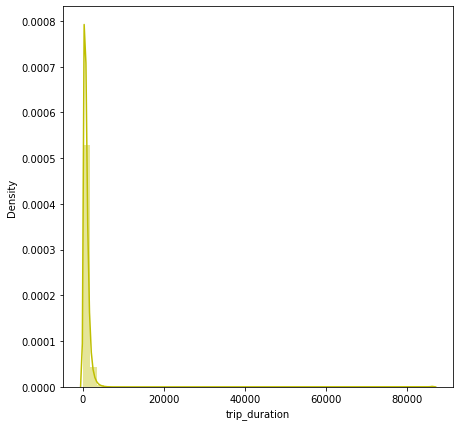

In [16]:
plt.figure(figsize=(7,7))
sns.distplot(df['trip_duration'],color="y")

In [17]:
#a function is created to calculate the distance from latitudes and longitudes
from math import radians, cos, sin, asin, sqrt
def haversine(df):
    lat1, lon1, lat2, lon2 = df.pickup_latitude,df.pickup_longitude,df.dropoff_latitude,df.dropoff_longitude 
    R = 3959.87433 # this is in miles.  For Earth radius in kilometers use 6372.8 km
    dLat = radians(lat2 - lat1)
    dLon = radians(lon2 - lon1)
    lat1 = radians(lat1)
    lat2 = radians(lat2)
    a = sin(dLat/2)**2 + cos(lat1)*cos(lat2)*sin(dLon/2)**2
    c = 2*asin(sqrt(a))
    return R * c

In [18]:
df['distance'] = df.apply(lambda x: haversine(x), axis = 1)

In [19]:
df.head()

,vendor_id,pickup_datetime,dropoff_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration,pickup_day,dropoff_day,distance
0,2,2016-03-14 17:24:55,2016-03-14 17:32:30,-73.982155,40.767937,-73.964630,40.765602,455,Monday,Monday,0.931401
1,1,2016-06-12 00:43:35,2016-06-12 00:54:38,-73.980415,40.738564,-73.999481,40.731152,663,Sunday,Sunday,1.122207
2,2,2016-01-19 11:35:24,2016-01-19 12:10:48,-73.979027,40.763939,-74.005333,40.710087,2124,Tuesday,Tuesday,3.968637
3,2,2016-04-06 19:32:31,2016-04-06 19:39:40,-74.010040,40.719971,-74.012268,40.706718,429,Wednesday,Wednesday,0.923307
4,2,2016-03-26 13:30:55,2016-03-26 13:38:10,-73.973053,40.793209,-73.972923,40.782520,435,Saturday,Saturday,0.738763


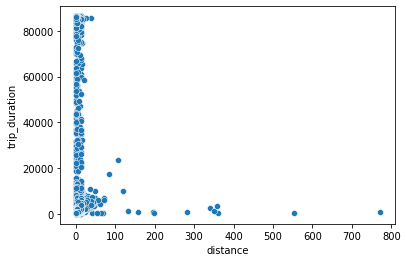

In [20]:
sns.scatterplot(x='distance',y='trip_duration',data=df)


In [21]:
df = df[df.distance != 0]

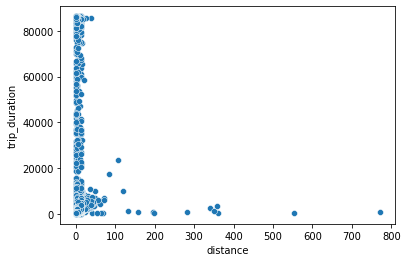

In [22]:
sns.scatterplot(x='distance',y='trip_duration',data=df)


In [23]:
df['pickup_month']=df['pickup_datetime'].dt.month
df['dropoff_month']=df['dropoff_datetime'].dt.month

In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1452743 entries, 0 to 1458643
Data columns (total 13 columns):
 #   Column             Non-Null Count    Dtype         
---  ------             --------------    -----         
 0   vendor_id          1452743 non-null  int64         
 1   pickup_datetime    1452743 non-null  datetime64[ns]
 2   dropoff_datetime   1452743 non-null  datetime64[ns]
 3   pickup_longitude   1452743 non-null  float64       
 4   pickup_latitude    1452743 non-null  float64       
 5   dropoff_longitude  1452743 non-null  float64       
 6   dropoff_latitude   1452743 non-null  float64       
 7   trip_duration      1452743 non-null  int64         
 8   pickup_day         1452743 non-null  object        
 9   dropoff_day        1452743 non-null  object        
 10  distance           1452743 non-null  float64       
 11  pickup_month       1452743 non-null  int64         
 12  dropoff_month      1452743 non-null  int64         
dtypes: datetime64[ns](2), float

In [25]:
df.head(3)

,vendor_id,pickup_datetime,dropoff_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration,pickup_day,dropoff_day,distance,pickup_month,dropoff_month
0,2,2016-03-14 17:24:55,2016-03-14 17:32:30,-73.982155,40.767937,-73.964630,40.765602,455,Monday,Monday,0.931401,3,3
1,1,2016-06-12 00:43:35,2016-06-12 00:54:38,-73.980415,40.738564,-73.999481,40.731152,663,Sunday,Sunday,1.122207,6,6
2,2,2016-01-19 11:35:24,2016-01-19 12:10:48,-73.979027,40.763939,-74.005333,40.710087,2124,Tuesday,Tuesday,3.968637,1,1


In [26]:
def timezone(x):
    if x>=datetime.time(4, 0, 1) and x <=datetime.time(10, 0, 0):
        return 'morning'
    elif x>=datetime.time(10, 0, 1) and x <=datetime.time(16, 0, 0):
        return 'midday'
    elif x>=datetime.time(16, 0, 1) and x <=datetime.time(22, 0, 0):
        return 'evening'
    elif x>=datetime.time(22, 0, 1) or x <=datetime.time(4, 0, 0):
        return 'late night'

In [27]:
df['pickup_timezone']=df['pickup_datetime'].apply(lambda x :timezone(datetime.datetime.strptime(str(x), "%Y-%m-%d %H:%M:%S").time()) )
df['dropoff_timezone']=df['dropoff_datetime'].apply(lambda x :timezone(datetime.datetime.strptime(str(x), "%Y-%m-%d %H:%M:%S").time()) )

In [28]:
df.head(3)

,vendor_id,pickup_datetime,dropoff_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration,pickup_day,dropoff_day,distance,pickup_month,dropoff_month,pickup_timezone,dropoff_timezone
0,2,2016-03-14 17:24:55,2016-03-14 17:32:30,-73.982155,40.767937,-73.964630,40.765602,455,Monday,Monday,0.931401,3,3,evening,evening
1,1,2016-06-12 00:43:35,2016-06-12 00:54:38,-73.980415,40.738564,-73.999481,40.731152,663,Sunday,Sunday,1.122207,6,6,late night,late night
2,2,2016-01-19 11:35:24,2016-01-19 12:10:48,-73.979027,40.763939,-74.005333,40.710087,2124,Tuesday,Tuesday,3.968637,1,1,midday,midday


In [29]:
df = df.drop(['pickup_datetime', 'dropoff_datetime',	'pickup_longitude',	'pickup_latitude',	'dropoff_longitude',	'dropoff_latitude'], axis = 1)

In [30]:
df = pd.get_dummies(df, columns = ['vendor_id',	'pickup_day',	'dropoff_day', 'pickup_month',	'dropoff_month',	'pickup_timezone',	'dropoff_timezone'])

In [31]:
df.head()

,trip_duration,distance,vendor_id_1,vendor_id_2,pickup_day_Friday,pickup_day_Monday,pickup_day_Saturday,pickup_day_Sunday,pickup_day_Thursday,pickup_day_Tuesday,...,dropoff_month_6,dropoff_month_7,pickup_timezone_evening,pickup_timezone_late night,pickup_timezone_midday,pickup_timezone_morning,dropoff_timezone_evening,dropoff_timezone_late night,dropoff_timezone_midday,dropoff_timezone_morning
0,455,0.931401,0,1,0,1,0,0,0,0,...,0,0,1,0,0,0,1,0,0,0
1,663,1.122207,1,0,0,0,0,1,0,0,...,1,0,0,1,0,0,0,1,0,0
2,2124,3.968637,0,1,0,0,0,0,0,1,...,0,0,0,0,1,0,0,0,1,0
3,429,0.923307,0,1,0,0,0,0,0,0,...,0,0,1,0,0,0,1,0,0,0
4,435,0.738763,0,1,0,0,1,0,0,0,...,0,0,0,0,1,0,0,0,1,0


In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1452743 entries, 0 to 1458643
Data columns (total 39 columns):
 #   Column                       Non-Null Count    Dtype  
---  ------                       --------------    -----  
 0   trip_duration                1452743 non-null  int64  
 1   distance                     1452743 non-null  float64
 2   vendor_id_1                  1452743 non-null  uint8  
 3   vendor_id_2                  1452743 non-null  uint8  
 4   pickup_day_Friday            1452743 non-null  uint8  
 5   pickup_day_Monday            1452743 non-null  uint8  
 6   pickup_day_Saturday          1452743 non-null  uint8  
 7   pickup_day_Sunday            1452743 non-null  uint8  
 8   pickup_day_Thursday          1452743 non-null  uint8  
 9   pickup_day_Tuesday           1452743 non-null  uint8  
 10  pickup_day_Wednesday         1452743 non-null  uint8  
 11  dropoff_day_Friday           1452743 non-null  uint8  
 12  dropoff_day_Monday           1452743 non-n

In [33]:
dependent_variables = 'trip_duration'

In [34]:
independent_variables = list(set(df.columns) - {'trip_duration'})

In [35]:
independent_variables

['pickup_timezone_late night',
 'dropoff_timezone_late night',
 'dropoff_month_6',
 'dropoff_month_3',
 'dropoff_day_Friday',
 'dropoff_month_2',
 'dropoff_day_Tuesday',
 'pickup_timezone_evening',
 'pickup_day_Wednesday',
 'dropoff_day_Thursday',
 'distance',
 'pickup_month_2',
 'dropoff_day_Wednesday',
 'pickup_month_5',
 'pickup_day_Sunday',
 'dropoff_day_Saturday',
 'dropoff_timezone_midday',
 'vendor_id_2',
 'dropoff_month_1',
 'pickup_day_Saturday',
 'pickup_day_Friday',
 'vendor_id_1',
 'pickup_day_Monday',
 'pickup_month_6',
 'pickup_day_Thursday',
 'dropoff_day_Sunday',
 'dropoff_month_7',
 'pickup_month_1',
 'pickup_day_Tuesday',
 'pickup_timezone_morning',
 'pickup_timezone_midday',
 'dropoff_day_Monday',
 'pickup_month_4',
 'dropoff_month_5',
 'dropoff_timezone_evening',
 'dropoff_timezone_morning',
 'dropoff_month_4',
 'pickup_month_3']

In [36]:
# from sklearn import  metrics
# from sklearn.model_selection import cross_val_score
# def modelfit(estimator,data_train,data_test,predictors,target):
#     #print(data_train.head())
#     #fitting model
#     estimator.fit(data_train[predictors],data_train.loc[:,target])
#     #train data prediction
#     train_pred=estimator.predict(data_train[predictors])
#     #cross_validation score
#     cv_score=cross_val_score(estimator,data_train[predictors],data_train.loc[:,target],cv=20,scoring='neg_mean_squared_error')
    
#     cv_score=np.sqrt(np.abs(cv_score))
#     #Print model report:
#     print ("\nModel Report")
#     print ("RMSE on Train Data: %.4g" % np.sqrt(metrics.mean_squared_error(data_train.loc[:,target].values, train_pred)))
#     print ("CV Score : Mean - %.4g | Std - %.4g | Min - %.4g | Max - %.4g" % (np.mean(cv_score),np.std(cv_score),np.min(cv_score),np.max(cv_score)))
    
#     test_pred=estimator.predict(data_test[predictors])
#     print ("RMSE on Test Data: %.4g" % np.sqrt(metrics.mean_squared_error(data_test.loc[:,target].values, test_pred)))
    
    
    
#     return test_pred

In [37]:
df.head()

,trip_duration,distance,vendor_id_1,vendor_id_2,pickup_day_Friday,pickup_day_Monday,pickup_day_Saturday,pickup_day_Sunday,pickup_day_Thursday,pickup_day_Tuesday,...,dropoff_month_6,dropoff_month_7,pickup_timezone_evening,pickup_timezone_late night,pickup_timezone_midday,pickup_timezone_morning,dropoff_timezone_evening,dropoff_timezone_late night,dropoff_timezone_midday,dropoff_timezone_morning
0,455,0.931401,0,1,0,1,0,0,0,0,...,0,0,1,0,0,0,1,0,0,0
1,663,1.122207,1,0,0,0,0,1,0,0,...,1,0,0,1,0,0,0,1,0,0
2,2124,3.968637,0,1,0,0,0,0,0,1,...,0,0,0,0,1,0,0,0,1,0
3,429,0.923307,0,1,0,0,0,0,0,0,...,0,0,1,0,0,0,1,0,0,0
4,435,0.738763,0,1,0,0,1,0,0,0,...,0,0,0,0,1,0,0,0,1,0


In [38]:
df2 = df.copy()

In [39]:
df2 = df2[df2['trip_duration'] < 2000]

In [40]:
df2 = df2[df2['distance'] < 5]

In [41]:
df2.head()

,trip_duration,distance,vendor_id_1,vendor_id_2,pickup_day_Friday,pickup_day_Monday,pickup_day_Saturday,pickup_day_Sunday,pickup_day_Thursday,pickup_day_Tuesday,...,dropoff_month_6,dropoff_month_7,pickup_timezone_evening,pickup_timezone_late night,pickup_timezone_midday,pickup_timezone_morning,dropoff_timezone_evening,dropoff_timezone_late night,dropoff_timezone_midday,dropoff_timezone_morning
0,455,0.931401,0,1,0,1,0,0,0,0,...,0,0,1,0,0,0,1,0,0,0
1,663,1.122207,1,0,0,0,0,1,0,0,...,1,0,0,1,0,0,0,1,0,0
3,429,0.923307,0,1,0,0,0,0,0,0,...,0,0,1,0,0,0,1,0,0,0
4,435,0.738763,0,1,0,0,1,0,0,0,...,0,0,0,0,1,0,0,0,1,0
5,443,0.683044,0,1,0,0,1,0,0,0,...,0,0,0,1,0,0,0,1,0,0


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


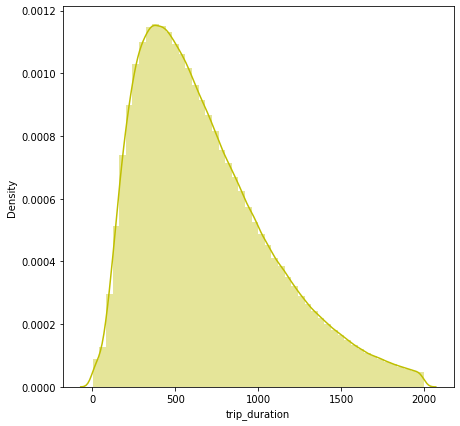

In [42]:
plt.figure(figsize=(7,7))
sns.distplot(df2.trip_duration,color="y")

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


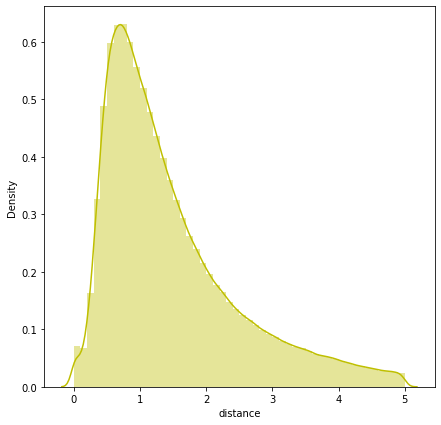

In [43]:
plt.figure(figsize=(7,7))
sns.distplot(df2.distance,color="y")

In [44]:
X = df2[independent_variables].values

In [45]:
y = df2[dependent_variables].values

In [46]:
X_train, X_test, y_train, y_test = train_test_split(X , y, test_size = 0.2, random_state = 0)

In [47]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

In [48]:
regressor = LinearRegression()
regressor.fit(X_train, y_train)

LinearRegression()

In [49]:
y_pred_train = regressor.predict(X_train)

In [50]:
y_pred_test = regressor.predict(X_test)

In [51]:
mean_squared_error(y_train, y_pred_train)

76136.68284642627

In [52]:
mean_squared_error(y_test, y_pred_test)

76083.69689300704

In [53]:
math.sqrt(mean_squared_error(y_train, y_pred_train))

275.92876407947443

In [54]:
math.sqrt(mean_squared_error(y_test, y_pred_test))

275.832733541556

In [55]:
r2_score(y_train, y_pred_train)

0.5252097652611888

In [56]:
r2_score(y_test, y_pred_test)

0.5240266652843174

In [57]:
xgr = XGBRegressor(random_state = 42, n_jobs = -1).fit(X_train, y_train)

[12:35:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [58]:
y_pred_train_xgb = xgr.predict(X_train)

In [59]:
y_pred_test_xgb = xgr.predict(X_test)

In [60]:
mean_squared_error(y_train, y_pred_train_xgb)

69120.13947622558

In [61]:
mean_squared_error(y_test, y_pred_test_xgb)

68882.8387544536

In [62]:
math.sqrt(mean_squared_error(y_train, y_pred_train_xgb))

262.9070928602452

In [63]:
math.sqrt(mean_squared_error(y_test, y_pred_test_xgb))

262.4554033630354

In [64]:
r2_score(y_train, y_pred_train_xgb)

0.5689651030201546

In [65]:
r2_score(y_test, y_pred_test_xgb)

0.5690746400934498

In [66]:
lasso = Lasso(alpha = 0.0001, max_iter = 3000)
lasso.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.237e+10, tolerance: 1.660e+07
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive


Lasso(alpha=0.0001, max_iter=3000)

In [67]:
lasso.score(X_train, y_train)

0.5252106755049852

In [ ]:
lasso = Lasso()
parameters = {'alpha': [1e-15,1e-13,1e-10,1e-8,1e-5,1e-4,1e-3,1e-2,1e-1,1,5,10,20,30,40,45,50,55,60,100,0.0014]}
lasso_regressor = GridSearchCV(lasso, parameters, scoring='neg_mean_squared_error', cv=5)
lasso_regressor.fit(X_train, y_train)

In [ ]:
print("The best fit alpha value is found out to be :" ,lasso_regressor.best_params_)
print("\nUsing ",lasso_regressor.best_params_, " the negative mean squared error is: ", lasso_regressor.best_score_)

In [ ]:
y_pred_lasso = lasso_regressor.predict(X_test)

In [ ]:
MSE  = mean_squared_error(10**(y_test), 10**(y_pred_lasso))
print("MSE :" , MSE)

RMSE = np.sqrt(MSE)
print("RMSE :" ,RMSE)

r2 = r2_score(10**(y_test), 10**(y_pred_lasso))
print("R2 :" ,r2)
print("Adjusted R2 : ",1-(1-r2_score(10**(y_test), 10**(y_pred_lasso)))*((X_test.shape[0]-1)/(X_test.shape[0]-X_test.shape[1]-1)))

In [69]:
ridge = Ridge()
parameters = {'alpha': [1e-15,1e-10,1e-8,1e-5,1e-4,1e-3,1e-2,1,5,10,20,30,40,45,50,55,60,100]}
ridge_regressor = GridSearchCV(ridge, parameters, scoring='neg_mean_squared_error', cv=3)
ridge_regressor.fit(X_train,y_train)

GridSearchCV(cv=3, estimator=Ridge(),
             param_grid={'alpha': [1e-15, 1e-10, 1e-08, 1e-05, 0.0001, 0.001,
                                   0.01, 1, 5, 10, 20, 30, 40, 45, 50, 55, 60,
                                   100]},
             scoring='neg_mean_squared_error')

In [70]:
print("The best fit alpha value is found out to be :" ,ridge_regressor.best_params_)
print("\nUsing ",ridge_regressor.best_params_, " the negative mean squared error is: ", ridge_regressor.best_score_)

The best fit alpha value is found out to be : {'alpha': 0.001}

Using  {'alpha': 0.001}  the negative mean squared error is:  -76142.77098198654


In [71]:
y_pred_ridge = ridge_regressor.predict(X_test)

In [73]:
MSE  = mean_squared_error(y_test, y_pred_ridge)
print("MSE :" , MSE)

RMSE = np.sqrt(MSE)
print("RMSE :" ,RMSE)

r2 = r2_score(y_test, y_pred_ridge)
print("R2 :" ,r2)
#print("Adjusted R2 : ",1-((1-r2_score(y_test), y_pred_ridge))*((X_test.shape[0]-1)/(X_test.shape[0]-X_test.shape[1]-1)))

MSE : 76082.56508813432
RMSE : 275.83068191942374
R2 : 0.5240337457622846


In [74]:
elasticnet = ElasticNet(alpha=0.1, l1_ratio=0.5)

In [75]:
elasticnet.fit(X_train,y_train)

ElasticNet(alpha=0.1)

In [76]:
elasticnet.score(X_train, y_train)

0.36539948461039595

In [77]:
y_pred_en = elasticnet.predict(X_test)


In [79]:
MSE  = mean_squared_error(y_test, y_pred_en)
print("MSE :" , MSE)

RMSE = np.sqrt(MSE)
print("RMSE :" ,RMSE)

r2 = r2_score(y_test, y_pred_en)
print("R2 :" ,r2)
#print("Adjusted R2 : ",1-((1-r2_score(y_test), y_pred_ridge))*((X_test.shape[0]-1)/(X_test.shape[0]-X_test.shape[1]-1)))

MSE : 101490.9636370392
RMSE : 318.5764643488894
R2 : 0.36508089934481625


In [80]:
elastic = ElasticNet()
parameters = {'alpha': [1e-15,1e-13,1e-10,1e-8,1e-5,1e-4,1e-3,1e-2,1e-1,1,5,10,20,30,40,45,50,55,60,100],'l1_ratio':[0.3,0.4,0.5,0.6,0.7,0.8]}
elastic_regressor = GridSearchCV(elastic, parameters, scoring='neg_mean_squared_error',cv=5)
elastic_regressor.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.150e+10, tolerance: 1.328e+07
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.156e+10, tolerance: 1.329e+07
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisa

KeyboardInterrupt: ignored

In [ ]:
print("The best fit alpha value is found out to be :" ,elastic_regressor.best_params_)
print("\nUsing ",elastic_regressor.best_params_, " the negative mean squared error is: ", elastic_regressor.best_score_)

In [ ]:
y_pred_elastic = elastic_regressor.predict(X_test)

In [ ]:
MSE  = mean_squared_error(y_test, y_pred_elastic)
print("MSE :" , MSE)

RMSE = np.sqrt(MSE)
print("RMSE :" ,RMSE)

r2 = r2_score(y_test, y_pred_elastic)
print("R2 :" ,r2)
print("Adjusted R2 : ",1-((1-r2_score(y_test), y_pred_ridge))*((X_test.shape[0]-1)/(X_test.shape[0]-X_test.shape[1]-1)))